In [ ]:
#importing the standard Python modules
import torch
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-25 19:24:28--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-25 19:24:29--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  18.5MB/s    in 1.8s    

2021-04-25 19:24:31 (18.5 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
# download and transform train dataset
batch_size=128
transform=transforms.Compose([
transforms.ToTensor(), # first, convert image to PyTorch tensor
transforms.Normalize((0.1307,), (0.3081,)) ])

TrainDataset = MNIST(root = './', train=True, download=True, transform=transform)
idx = (TrainDataset.train_labels==6)+(TrainDataset.train_labels==9)
TrainDataset.targets = TrainDataset.train_labels[idx]
TrainDataset.data = TrainDataset.train_data[idx]
TrainDataset.targets = TrainDataset.train_labels==9 #we have ones at digit nine, zero otherwise
trainloader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_size, shuffle=True)

# download and transform test dataset
TestDataset = datasets.MNIST(root = './', train=True, download=True, transform=transform)
idx = (TestDataset.train_labels==6) + (TestDataset.train_labels==9)
TestDataset.targets = TestDataset.train_labels[idx]
TestDataset.data = TestDataset.train_data[idx]
TestDataset.targets = TestDataset.train_labels==9 #we have ones at digit nine, zero otherwise
test_loader = torch.utils.data.DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([11867, 28, 28])
torch.Size([11867])
tensor(True)


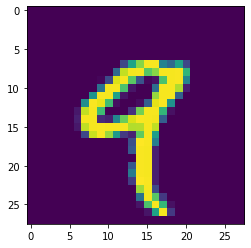

In [ ]:
print(TrainDataset.train_data.shape)
print(TrainDataset.train_labels.shape)
plt.imshow(TrainDataset.train_data[0,:,:])
print(TrainDataset.train_labels[0])

In [ ]:
class CeNNLayer(torch.nn.Module):
    def __init__(self, InDepth=1, OutDepth=1,TimeStep=0.1,IterNum=10):
        super(CeNNLayer, self).__init__()
        self.rescale= torch.nn.Conv2d(InDepth, OutDepth, kernel_size=3, padding=1,bias=False)
        self.A= torch.nn.Conv2d(OutDepth, OutDepth, kernel_size=3, padding=1,bias=False)
        self.B= torch.nn.Conv2d(InDepth, OutDepth, kernel_size=3, padding=1 ,bias=False)
        self.Z= torch.nn.Parameter(torch.randn(OutDepth))
        #self.TimeStep=torch.nn.Parameter(torch.tensor(0.1))
        self.TimeStep=TimeStep      
        self.IterNum=IterNum
        
    def NonLin(self,x,alpha=0.01):
    	y= torch.min(x,1+alpha*(x-1))
    	y= torch.max(y,-1+alpha*(y+1))
    	return y
           
    def forward(self, x):
        InputCoupling=self.B(x)
        Zreshaped=self.Z.view(1,InputCoupling.shape[1],1,1).repeat(InputCoupling.shape[0],1,InputCoupling.shape[2],InputCoupling.shape[3])
        InputCoupling=InputCoupling+Zreshaped
        x=self.rescale(x)
        for step in range(self.IterNum):
            Coupling=self.A(self.NonLin(x)) + InputCoupling
            x=x+self.TimeStep*(-x+Coupling)
        return self.NonLin(x)


class CellNN(torch.nn.Module):
    def __init__(self):
        super(CellNN, self).__init__()
        self.Layer1= CeNNLayer(1,4)
        self.Layer2= CeNNLayer(4,4)
        self.Layer3= CeNNLayer(4,1)

        

    def forward(self, x):
    	x=self.Layer1(x)
    	x=self.Layer2(x)
    	x=self.Layer3(x)
     

    	return x




Net=CellNN()

opt = torch.optim.Adam(Net.parameters(), lr=1e-3)

for i in range(3):   
    print("Epoch")
    for batch_id, (data, label) in enumerate(trainloader):
        opt.zero_grad()
        x=data
        Input=data
        out=Net(data)
        ExpectedOut=torch.ones_like(out)
        ExpectedOut[label==0,:,:,:]=-1
        loss=torch.mean(torch.abs(ExpectedOut-out))
        loss.backward()
        opt.step()

        if batch_id%10==0:
            #Accuracy
            CorrectDistance = torch.mean( torch.abs(ExpectedOut-out),[1,2,3] )
            InCorrectDistance = torch.mean( torch.abs((-1*ExpectedOut)-out),[1,2,3] )
            Corrects= torch.greater(InCorrectDistance,CorrectDistance)
            Acc=torch.mean(Corrects.float())
            print("Loss: "+str(loss.item())+" Acc: "+str(Acc.item()))
        


Epoch
Loss: 1.043576717376709 Acc: 0.4765625 Alpha: 0.5
Loss: 0.9537564516067505 Acc: 0.5234375 Alpha: 0.5
Loss: 0.9232450723648071 Acc: 0.5390625 Alpha: 0.5
Loss: 1.0165237188339233 Acc: 0.4921875 Alpha: 0.5
Loss: 0.9076728224754333 Acc: 0.546875 Alpha: 0.5
Loss: 0.9542255997657776 Acc: 0.5234375 Alpha: 0.5
Loss: 1.0672675371170044 Acc: 0.4609375 Alpha: 0.5
Loss: 1.0693507194519043 Acc: 0.4453125 Alpha: 0.5
Loss: 1.0642337799072266 Acc: 0.4453125 Alpha: 0.5
Loss: 0.9466972351074219 Acc: 0.5234375 Alpha: 0.5
Epoch
Loss: 0.9975563883781433 Acc: 0.4921875 Alpha: 0.5
Loss: 0.9476617574691772 Acc: 0.53125 Alpha: 0.5
Loss: 0.9072542190551758 Acc: 0.5546875 Alpha: 0.5
Loss: 0.9636706113815308 Acc: 0.4921875 Alpha: 0.5
Loss: 0.9646791815757751 Acc: 0.484375 Alpha: 0.5
Loss: 0.9385798573493958 Acc: 0.546875 Alpha: 0.5
Loss: 0.9339215159416199 Acc: 0.5859375 Alpha: 0.5
Loss: 0.8971961736679077 Acc: 0.6484375 Alpha: 0.5
Loss: 0.9303585886955261 Acc: 0.7109375 Alpha: 0.5
Loss: 0.8894192576408386 